<a href="https://colab.research.google.com/github/ksee1230/NL_team12/blob/master/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_Friends_12%EC%A1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

모듈 import, 데이터 로드 및 one-hot encoding을 위한 전처리

In [1]:
import pandas as pd
import json
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

urllib.request.urlretrieve("https://raw.githubusercontent.com/ksee1230/NL_team12/master/friends_train.json", filename="friends_train.json")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ksee1230/NL_team12/master/en_data.csv", filename="friends_test.csv")

test_data = pd.read_csv('friends_test.csv', encoding='utf-8')

with open('friends_train.json') as json_file:
    json_data = json.load(json_file)

train_data = []
for data in json_data:
  train_data = train_data + data

for idx in train_data:
  if (idx['emotion'] == 'non-neutral'):
    idx['emotion_num'] = 0
  elif (idx['emotion'] == 'neutral'):
    idx['emotion_num'] = 1
  elif (idx['emotion'] == 'joy'):
    idx['emotion_num'] = 2
  elif (idx['emotion'] == 'sadness'):
    idx['emotion_num'] = 3
  elif (idx['emotion'] == 'fear'):
    idx['emotion_num'] = 4
  elif (idx['emotion'] == 'anger'):
    idx['emotion_num'] = 5
  elif (idx['emotion'] == 'surprise'):
    idx['emotion_num'] = 6
  elif (idx['emotion'] == 'disgust'):
    idx['emotion_num'] = 7

result = pd.DataFrame(train_data, columns=['annotation', 'emotion', 'emotion_num', 'utterance'])

print('훈련용 데이터 개수 :',len(result))

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
훈련용 데이터 개수 : 10561


# 데이터 정제


(1) 중복 데이터 제거 및 문장 기호 제거

In [2]:
result['utterance'].nunique()

9291

In [3]:
result.drop_duplicates(subset=['utterance'], inplace=True)

In [4]:
print('총 샘플의 수 :',len(result))

총 샘플의 수 : 9291


In [5]:
print(result.isnull().values.any())

False


In [6]:
result['utterance'] = result['utterance'].str.replace("[^a-zA-Z ]","")
result[:5]

,annotation,emotion,emotion_num,utterance
0,4100000,neutral,1,also I was the point person on my companys tra...
1,5000000,neutral,1,You mustve had your hands full
2,5000000,neutral,1,That I did That I did
3,5000000,neutral,1,So lets talk a little bit about your duties
4,2000030,surprise,6,My duties All right


In [7]:
result = result.dropna(how = 'any')
print(len(result))

9291


(2) 불용어 제거 및 토큰화

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
X_train = []
for sentence in result['utterance']:
    temp_X = []
    word_tokens = word_tokenize(sentence)
    for word in word_tokens:
      if word not in stop_words:
        temp_X.append(word)
    X_train.append(temp_X)

In [10]:
print(X_train[:3])

[['also', 'I', 'point', 'person', 'companys', 'transition', 'KL', 'GR', 'system'], ['You', 'mustve', 'hands', 'full'], ['That', 'I', 'That', 'I']]


In [11]:
X_test = []
for sentence in test_data['utterance']:
    temp_X = []
    word_tokens = word_tokenize(sentence)
    for word in word_tokens:
      if word not in stop_words:
        temp_X.append(word)
    X_test.append(temp_X)

(3) 정수 인코딩

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
total_cnt = len(tokenizer.word_index)
vocab_size = total_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5935


In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
y_train = np_utils.to_categorical(result['emotion_num'])
num_classes = y_train.shape[1]

(4) 패딩

문장의 최대 길이 : 39
문장의 평균 길이 : 5.398019588849424


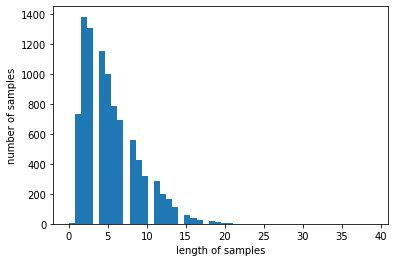

In [16]:
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 24
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 24 이하인 샘플의 비율: 99.96771068776235


In [18]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 모델 설계 및 학습

In [19]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='softmax'))

In [21]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
ckpt = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[earlystop, ckpt], batch_size=128, validation_split=0.2)

Epoch 1/15
58/59 [============================>.] - ETA: 0s - loss: 1.6470 - acc: 0.4410
Epoch 00001: val_acc improved from -inf to 0.22109, saving model to best_model.h5
59/59 [==============================] - 6s 104ms/step - loss: 1.6472 - acc: 0.4407 - val_loss: 1.6681 - val_acc: 0.2211
Epoch 2/15
58/59 [============================>.] - ETA: 0s - loss: 1.5640 - acc: 0.4457
Epoch 00002: val_acc improved from 0.22109 to 0.45186, saving model to best_model.h5
59/59 [==============================] - 6s 97ms/step - loss: 1.5642 - acc: 0.4458 - val_loss: 1.5782 - val_acc: 0.4519
Epoch 3/15
58/59 [============================>.] - ETA: 0s - loss: 1.4296 - acc: 0.4996
Epoch 00003: val_acc improved from 0.45186 to 0.45777, saving model to best_model.h5
59/59 [==============================] - 6s 97ms/step - loss: 1.4299 - acc: 0.4996 - val_loss: 1.5545 - val_acc: 0.4578
Epoch 4/15
58/59 [============================>.] - ETA: 0s - loss: 1.3166 - acc: 0.5475
Epoch 00004: val_acc improved f

모델을 통해 test 데이터에 대한 결과 예측 및 csv 변환

In [23]:
loaded_model = load_model('best_model.h5')
prediction = loaded_model.predict_classes(X_test, verbose=0)

prediction = prediction.flatten().tolist()

prediction_emotion = []
for num in prediction:
  if num == 0:
    prediction_emotion.append('non-neutral')
  elif num == 1:
    prediction_emotion.append('neutral')
  elif num == 2:
    prediction_emotion.append('joy')
  elif num == 3:
    prediction_emotion.append('sadness')
  elif num == 4:
    prediction_emotion.append('fear')
  elif num == 5:
    prediction_emotion.append('anger')
  elif num == 6:
    prediction_emotion.append('surprise')
  elif num == 7:
    prediction_emotion.append('disgust')

id = list(range(len(prediction_emotion)))

dic = {'Id': id,
       'Predicted': prediction_emotion}

df = pd.DataFrame(dic)
df.to_csv('sample.csv', sep=',', index = False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
